# Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

<br>
The system run the experiment:
<ul>
    <li> Ubuntu 22.04.03
    <li> RTX 3060
    <li> Cuda 11.8
    <li> Python 3.10 - Tensorflow 2.12.1
</ul>

# Inport libraries and defind paramters

In [1]:
# ------------------------------------------------------------------------
# Run the code below to install the environment (conda)
# ------------------------------------------------------------------------

# %conda create -n melanoma python=3.10 ipython
# %conda activate melanoma
# %python3 -m pip install tensorflow[and-cuda]
# %pip install opencv-python matplotlib seaborn scikit-learn scikit-image jupyter lenskit
# %pip install Augmentor

In [46]:
# ------------------------------------------------------------------------
# Import libraries
# ------------------------------------------------------------------------
import os
import pathlib
import shutil
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Activation
from keras.layers import MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling
from sklearn.metrics import confusion_matrix
import Augmentor
import warnings
warnings.filterwarnings('ignore')


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
sys_details = tf.sysconfig.get_build_info()
cuda = sys_details["cuda_version"]
cudnn = sys_details["cudnn_version"]
print(cuda, cudnn)

11.8 8


2023-10-24 18:08:14.558666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 18:08:14.618632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 18:08:14.618801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# ------------------------------------------------------------------------
# Path of data
# ------------------------------------------------------------------------
data_dir_train = pathlib.Path("./data/Train")
data_dir_test = pathlib.Path("./data/Test")

In [5]:
# ------------------------------------------------------------------------
# Global parameters
# ------------------------------------------------------------------------
seed = 42
batch_size = 32
img_height = 180
img_width = 180

# EDA

## 1. Number of samples

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Total train samples:', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Total test samples:', image_count_test)

Total train samples: 2239
Total test samples: 118


## 2. Sample per classes and class balance

In [7]:
data_detail_pd = pd.DataFrame(columns=["Dir_Name","Total Image(Train)","Total Percentage(Train)","Total Image(Test)","Total Percentage(Test)"])
# train data in each folders
for dir_name in glob.glob(os.path.join(data_dir_train, "*")):
  total_image_in_folder = len(glob.glob(os.path.join(dir_name, "*.jpg")))
  df = {"Dir_Name":os.path.basename(dir_name),"Total Image(Train)":total_image_in_folder,"Total Percentage(Train)":round((total_image_in_folder/image_count_train)*100,2)}
  data_detail_pd = data_detail_pd.append(df,ignore_index=True)
data_detail_pd = data_detail_pd.set_index("Dir_Name")
# test data in each folders
for dir_name in glob.glob(os.path.join(data_dir_test, "*")):
  total_image_in_folder = len(glob.glob(os.path.join(dir_name, "*.jpg")))
  data_detail_pd.loc[os.path.basename(dir_name),"Total Image(Test)"]  = total_image_in_folder
  data_detail_pd.loc[os.path.basename(dir_name),"Total Percentage(Test)"]  = round((total_image_in_folder/image_count_test)*100,2)
# data_detail_pd = data_detail_pd.set_index("Dir_Name")
display(data_detail_pd.sort_values(by="Total Percentage(Train)",ascending=False))

,Total Image(Train),Total Percentage(Train),Total Image(Test),Total Percentage(Test)
Dir_Name,,,,
pigmented benign keratosis,462,20.63,16,13.56
melanoma,438,19.56,16,13.56
basal cell carcinoma,376,16.79,16,13.56
nevus,357,15.94,16,13.56
squamous cell carcinoma,181,8.08,16,13.56
vascular lesion,139,6.21,3,2.54
actinic keratosis,114,5.09,16,13.56
dermatofibroma,95,4.24,16,13.56
seborrheic keratosis,77,3.44,3,2.54


Observation :
<ul>
    <li>Melanoma has 19.56% of data in train and 13.56% data in test data set.
    <li>Highest Sample of Data : pigmented benign keratosis (20.63%)
    <li>Lowest Sample of Data : seborrheic keratosis (3.44% in train and 2.54% in test)
</ul>

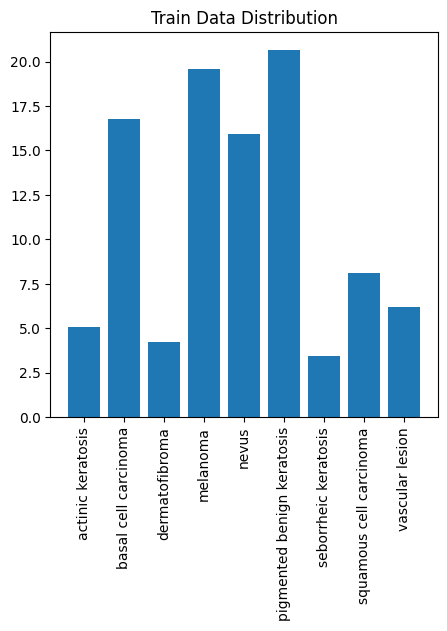

In [8]:
plt.figure(figsize=(5,5))
plt.bar(data_detail_pd.index,data_detail_pd['Total Percentage(Train)'])
plt.xticks(rotation=90)
plt.title("Train Data Distribution")
plt.show()

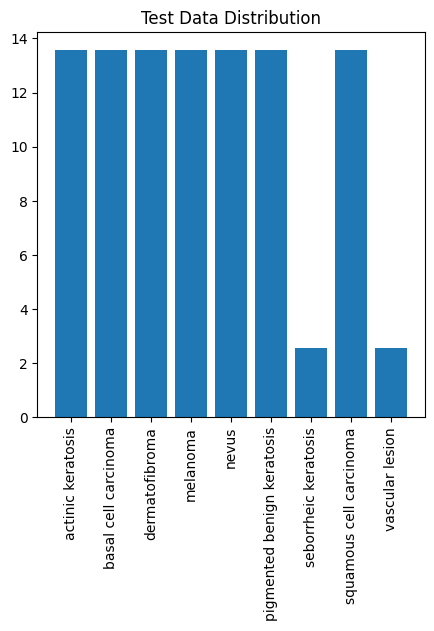

In [9]:
plt.figure(figsize=(5,5))
plt.bar(data_detail_pd.index,data_detail_pd['Total Percentage(Test)'])
plt.xticks(rotation=90)
plt.title("Test Data Distribution")
plt.show()

Class imbalanced, distribution of data different in train and test

# Prepare dataset, functions for Tranining and Evaluation and Visualize some data

## 1. Prepare dataset

In [10]:
# ------------------------------------------------------------------------
# Split the Train folder to Train and Validation dataset
# ------------------------------------------------------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
    interpolation='bicubic',
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bicubic',
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2023-10-24 18:08:15.257849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 18:08:15.258058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 18:08:15.258435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 2. Visualize data

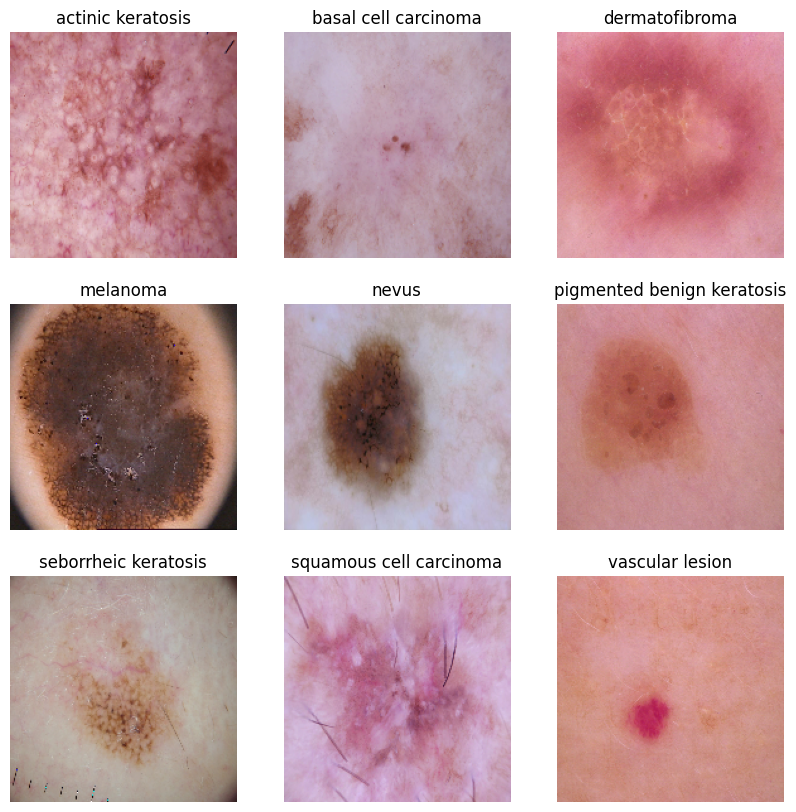

In [13]:
import matplotlib.pyplot as plt
import copy
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))

# get image each class
class_names_draw = [[] for i in range(len(class_names))]
count = 0
while count < len(class_names):
    for images, labels in train_ds.take(10):
        for i in range(batch_size):
            class_index = class_names.index(class_names[labels[i]])
            if class_names_draw[class_index] == []:
                class_names_draw[class_index] = images[i].numpy().astype("uint8")
                count +=1
    

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(class_names_draw[i])
    plt.title(class_names[i])
    plt.axis("off")
plt.show()

## 3. Functions support training process

In [14]:
def visualize_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Training Process

In [15]:
input_shape = (img_width, img_height, 3)
num_classes = 9

## 1. Model 1: Simple conv2d

In [16]:
# ------------------------------------------------------------------------
# Create model
# ------------------------------------------------------------------------
model1 = Sequential([
        layers.Rescaling(1./255,input_shape=input_shape),
        layers.Conv2D(16,3,padding='same',activation="relu"),
        layers.MaxPool2D((2,2),strides=2),
        layers.Conv2D(32,3,padding='same',activation="relu"),
        layers.MaxPool2D((2,2),strides=2),
        layers.Conv2D(64,3,padding='same',activation="relu"),
        layers.MaxPool2D((2,2),strides=2),
        layers.Flatten(),
        layers.Dense(128,activation="relu"),
        layers.Dense(num_classes)
        ],
        name = 'Model_01')

# ------------------------------------------------------------------------
# Compile model
# ------------------------------------------------------------------------
model1.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ------------------------------------------------------------------------
# View model
# ------------------------------------------------------------------------
model1.summary()

Model: "Model_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        184

In [17]:
# ------------------------------------------------------------------------
# Train model
# ------------------------------------------------------------------------
epochs = 30
history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs)
model1.save('model1.h5')

Epoch 1/30


2023-10-24 18:08:23.603095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-24 18:08:23.991638: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x799b000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-24 18:08:23.991679: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-10-24 18:08:23.997076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-24 18:08:24.081997: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 [==============================] - 5s 40ms/step - loss: 2.1365 - accuracy: 0.2305 - val_loss: 1.8726 - val_accuracy: 0.2975
Epoch 2/30
56/56 [==============================] - 1s 16ms/step - loss: 1.7730 - accuracy: 0.3610 - val_loss: 1.6263 - val_accuracy: 0.4161
Epoch 3/30
56/56 [==============================] - 1s 16ms/step - loss: 1.5086 - accuracy: 0.4654 - val_loss: 1.3742 - val_accuracy: 0.5034
Epoch 4/30
56/56 [==============================] - 1s 16ms/step - loss: 1.3639 - accuracy: 0.5084 - val_loss: 1.3065 - val_accuracy: 0.5391
Epoch 5/30
56/56 [==============================] - 1s 16ms/step - loss: 1.2757 - accuracy: 0.5525 - val_loss: 1.2620 - val_accuracy: 0.5638
Epoch 6/30
56/56 [==============================] - 1s 17ms/step - loss: 1.1716 - accuracy: 0.5843 - val_loss: 1.1346 - val_accuracy: 0.6085
Epoch 7/30
56/56 [==============================] - 1s 16ms/step - loss: 1.0830 - accuracy: 0.6272 - val_loss: 1.0250 - val_accuracy: 0.6264
Epoch 8/30
56/56 [======

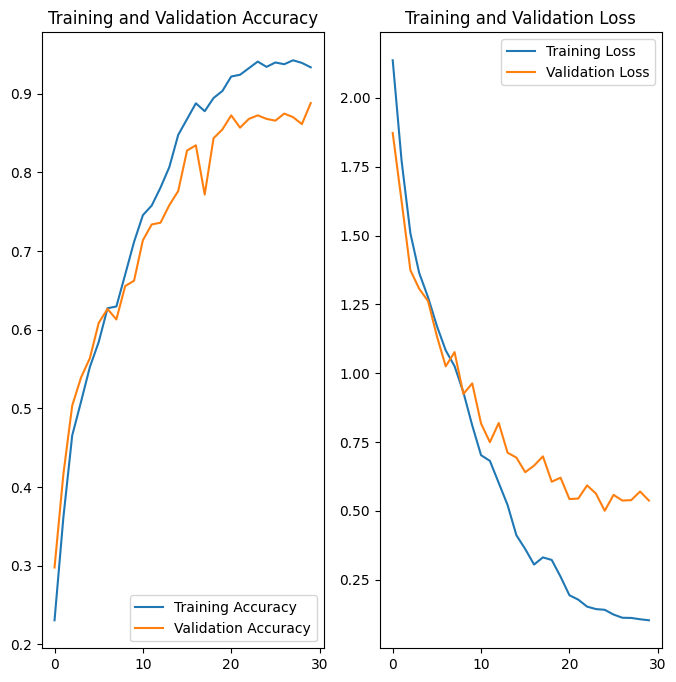

In [18]:
# ------------------------------------------------------------------------
# Visualize model
# ------------------------------------------------------------------------
visualize_history(history, epochs)

<strong>Findings</strong>
<ul>
    <li>Training Accuracy : Training Accuracy is high
    <li>Validation Accuracy : Validation accuracy is near Training loss -> it could be a good fit
    <li>Training Loss : Its decerasing
    <li>Validation Loss : Its decerasing,but after epoch 15 seems remain unchange -> maybe model too simple, reach the limit at epoch 15
</ul>

## 2. Model 2: Model with some Augmentation

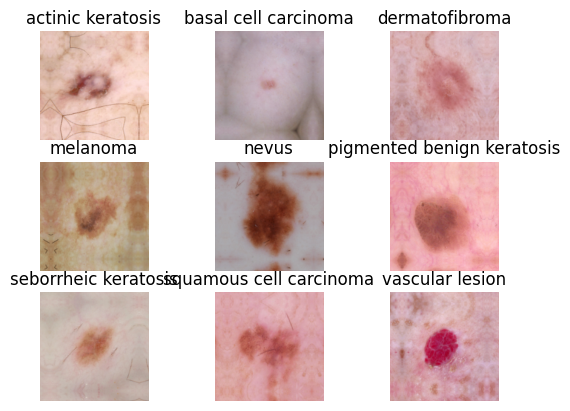

In [19]:
# ------------------------------------------------------------------------
# Define augmentation method
# ------------------------------------------------------------------------
data_augument = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=input_shape),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
    ])

# ------------------------------------------------------------------------
# Visualize how augmentation work
# ------------------------------------------------------------------------
class_names_draw = [[] for i in range(len(class_names))]
count = 0
while count < len(class_names):
    for images, labels in train_ds.take(10):
        # augmentation images
        images = data_augument(images)
        for i in range(batch_size):
            class_index = class_names.index(class_names[labels[i]])
            if class_names_draw[class_index] == []:
                class_names_draw[class_index] = images[i].numpy().astype("uint8")
                count +=1
    

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(class_names_draw[i])
    plt.title(class_names[i])
    plt.axis("off")
plt.show()

In [20]:
# ------------------------------------------------------------------------
# Create model
# ------------------------------------------------------------------------
model2 = Sequential([
    data_augument,
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.Conv2D(32,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.Conv2D(64,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.Dropout(0.2), # droupout layer
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(num_classes)
    ],
    name="Model_02")

# ------------------------------------------------------------------------
# Compile model
# ------------------------------------------------------------------------
model2.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ------------------------------------------------------------------------
# View model
# ------------------------------------------------------------------------
model2.summary()

Model: "Model_02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                     

In [21]:
# ------------------------------------------------------------------------
# Train model
# ------------------------------------------------------------------------
epochs = 30
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs)
model2.save('model2.h5')

Epoch 1/30


2023-10-24 18:08:58.463605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_02/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 4s 24ms/step - loss: 1.9630 - accuracy: 0.2723 - val_loss: 1.8003 - val_accuracy: 0.3579
Epoch 2/30
56/56 [==============================] - 1s 22ms/step - loss: 1.7511 - accuracy: 0.3666 - val_loss: 1.5910 - val_accuracy: 0.4497
Epoch 3/30
56/56 [==============================] - 1s 23ms/step - loss: 1.6743 - accuracy: 0.3800 - val_loss: 1.5540 - val_accuracy: 0.4251
Epoch 4/30
56/56 [==============================] - 1s 22ms/step - loss: 1.5396 - accuracy: 0.4364 - val_loss: 1.5009 - val_accuracy: 0.4474
Epoch 5/30
56/56 [==============================] - 1s 22ms/step - loss: 1.5442 - accuracy: 0.4537 - val_loss: 1.4303 - val_accuracy: 0.5011
Epoch 6/30
56/56 [==============================] - 1s 22ms/step - loss: 1.4521 - accuracy: 0.4978 - val_loss: 1.3851 - val_accuracy: 0.5459
Epoch 7/30
56/56 [==============================] - 1s 22ms/step - loss: 1.4184 - accuracy: 0.5112 - val_loss: 1.4242 - val_accuracy: 0.5056
Epoch 8/30
56/56 [======

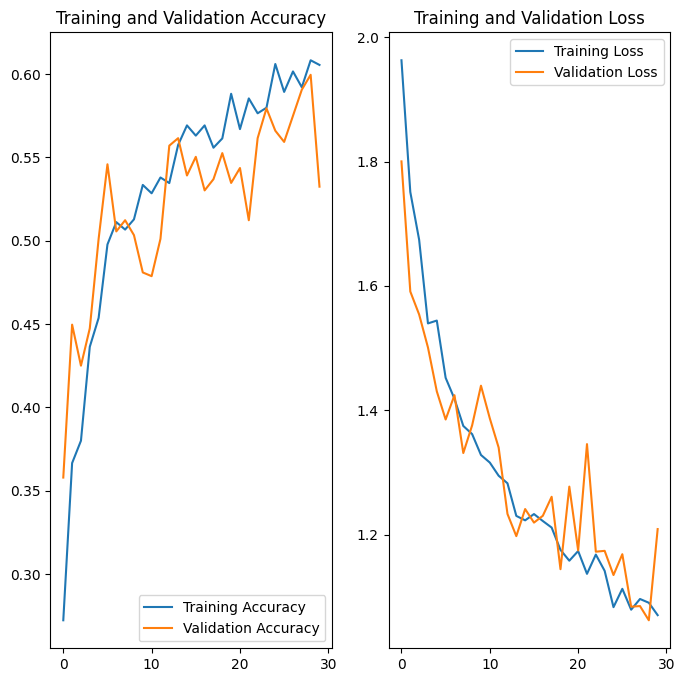

In [22]:
# ------------------------------------------------------------------------
# Visualize model
# ------------------------------------------------------------------------
visualize_history(history, epochs)

<strong> Findings </strong>
<ul>
    <li>The training accuracy go down (underfit), but the distance between train and validation go down to
    <li> More data -> More generalization of data, but model too simple -> Try to add more layers
    <li>The analysis before have show that class is imbalanced and ditribution of classes in train and test is different
</ul>

## 3. Model 3: Add more layers

In [23]:
# ------------------------------------------------------------------------
# Create model
# ------------------------------------------------------------------------
model3 = Sequential([
    data_augument,
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(32,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.Dropout(0.25), # droupout layer

    layers.Conv2D(64,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.Dropout(0.25), # droupout layer

    layers.Conv2D(128,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.Dropout(0.25), # droupout layer

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.25), # droupout layer
    
    layers.Dense(num_classes)],
    name="Model_03"
    )

# ------------------------------------------------------------------------
# Compile model
# ------------------------------------------------------------------------
model3.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ------------------------------------------------------------------------
# View model
# ------------------------------------------------------------------------
model3.summary()

Model: "Model_03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                     

In [24]:
# ------------------------------------------------------------------------
# Train model
# ------------------------------------------------------------------------
epochs = 70
history = model3.fit(train_ds, validation_data=val_ds, epochs=epochs)
model3.save('model3.h5')

Epoch 1/70
56/56 [==============================] - 3s 28ms/step - loss: 2.1296 - accuracy: 0.1970 - val_loss: 2.0725 - val_accuracy: 0.1924
Epoch 2/70
56/56 [==============================] - 1s 24ms/step - loss: 2.0381 - accuracy: 0.1987 - val_loss: 2.0873 - val_accuracy: 0.2081
Epoch 3/70
56/56 [==============================] - 2s 27ms/step - loss: 2.0033 - accuracy: 0.2455 - val_loss: 1.8242 - val_accuracy: 0.3266
Epoch 4/70
56/56 [==============================] - 1s 26ms/step - loss: 1.7619 - accuracy: 0.3583 - val_loss: 1.6615 - val_accuracy: 0.3937
Epoch 5/70
56/56 [==============================] - 1s 24ms/step - loss: 1.6617 - accuracy: 0.3806 - val_loss: 1.6347 - val_accuracy: 0.3915
Epoch 6/70
56/56 [==============================] - 1s 24ms/step - loss: 1.6229 - accuracy: 0.4263 - val_loss: 1.5988 - val_accuracy: 0.4340
Epoch 7/70
56/56 [==============================] - 1s 24ms/step - loss: 1.6031 - accuracy: 0.4241 - val_loss: 1.5649 - val_accuracy: 0.4452
Epoch 8/70
56

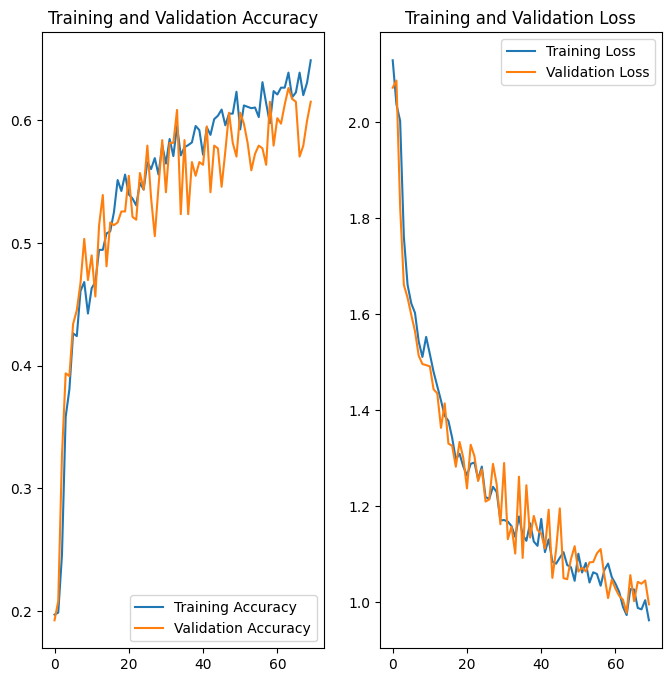

In [25]:
# ------------------------------------------------------------------------
# Visualize model
# ------------------------------------------------------------------------
visualize_history(history, epochs)

<strong>Findings</strong>
<ul>
<li>Model has no Overfitting : as both train & validation accuracy move close to overlap
<li>Loss more stable, but still underfit
</ul>

## Model 4: Add BatchNorm

In [26]:
# ------------------------------------------------------------------------
# Create model
# ------------------------------------------------------------------------
model4 = Sequential([
    data_augument,
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.BatchNormalization(),
    layers.Dropout(0.25), # droupout layer

    layers.Conv2D(32,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.BatchNormalization(),
    layers.Dropout(0.25), # droupout layer

    layers.Conv2D(64,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.BatchNormalization(),
    layers.Dropout(0.25), # droupout layer

    layers.Conv2D(128,3,padding='same',activation="relu"),
    layers.MaxPool2D((2,2),strides=2),
    layers.BatchNormalization(),
    layers.Dropout(0.25), # droupout layer

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    
    layers.Dense(num_classes)],
    name = "Model_04")

# ------------------------------------------------------------------------
# Compile model
# ------------------------------------------------------------------------
model4.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ------------------------------------------------------------------------
# View model
# ------------------------------------------------------------------------
model4.summary()

Model: "Model_04"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization (Batch  (None, 90, 90, 16)        64        
 Normalization)                                                  
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 16)        0  

In [27]:
# ------------------------------------------------------------------------
# Train model
# ------------------------------------------------------------------------
epochs = 70
history = model4.fit(train_ds, validation_data=val_ds, epochs=epochs)
model4.save('model4.h5')

Epoch 1/70


2023-10-24 18:11:29.846777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_04/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 4s 32ms/step - loss: 2.2585 - accuracy: 0.3454 - val_loss: 3.4128 - val_accuracy: 0.2058
Epoch 2/70
56/56 [==============================] - 2s 29ms/step - loss: 1.6678 - accuracy: 0.4062 - val_loss: 5.1132 - val_accuracy: 0.0537
Epoch 3/70
56/56 [==============================] - 2s 30ms/step - loss: 1.5605 - accuracy: 0.4615 - val_loss: 7.5292 - val_accuracy: 0.0872
Epoch 4/70
56/56 [==============================] - 2s 28ms/step - loss: 1.4783 - accuracy: 0.4883 - val_loss: 7.8359 - val_accuracy: 0.0872
Epoch 5/70
56/56 [==============================] - 2s 27ms/step - loss: 1.4058 - accuracy: 0.4983 - val_loss: 6.9248 - val_accuracy: 0.0962
Epoch 6/70
56/56 [==============================] - 2s 28ms/step - loss: 1.3351 - accuracy: 0.5212 - val_loss: 6.8267 - val_accuracy: 0.0872
Epoch 7/70
56/56 [==============================] - 2s 27ms/step - loss: 1.3316 - accuracy: 0.5324 - val_loss: 5.8273 - val_accuracy: 0.1834
Epoch 8/70
56/56 [======

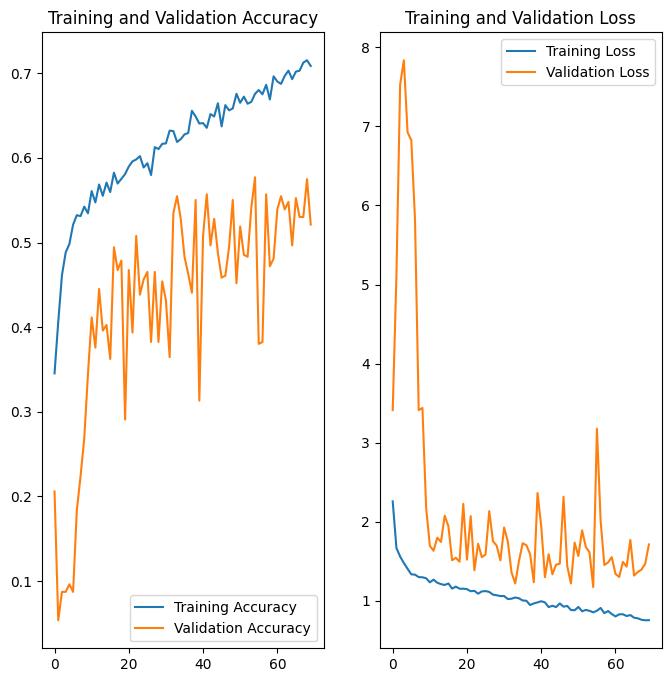

In [28]:
# ------------------------------------------------------------------------
# Visualize model
# ------------------------------------------------------------------------
visualize_history(history, epochs)

<strong>Findings</strong>
<ul>
    <li>No Additional improvement, its due to very less number of data
    <li>Try improve number of data
</ul>

## Model 5: BatchNorm with more image by Augmentor

### Data balancing

In [29]:
# ------------------------------------------------------------------------
# Define folder contain augmentation
# Note that validation data should not contain augmentation
# https://datascience.stackexchange.com/questions/41422/when-using-data-augmentation-is-it-ok-to-validate-only-with-the-original-images
# -> Split the origin data to 2 folder: Train_Aug and val_Aug (0.8:0.2 ratio)
# ------------------------------------------------------------------------
data_dir_train_aug = pathlib.Path(str(data_dir_train) + '_Aug') # Add prefix 
data_dir_val_aug = pathlib.Path(os.path.join(os.path.dirname(str(data_dir_train_aug)), 'val_Aug'))

if os.path.exists(data_dir_train_aug):
    shutil.rmtree(data_dir_train_aug)
os.mkdir(data_dir_train_aug)

if os.path.exists(data_dir_val_aug):
    shutil.rmtree(data_dir_val_aug)
os.mkdir(data_dir_val_aug)

# Get a list of subfolders in original folder (data classes)
subfolders = [f for f in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, f))]

# Iterate through the subfolders and divide the images
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir_train, subfolder)
    images = os.listdir(subfolder_path)
    total_images = len(images)
    
    os.makedirs(os.path.join(data_dir_train_aug, subfolder), exist_ok=True)
    os.makedirs(os.path.join(data_dir_val_aug, subfolder), exist_ok=True)

    # Calculate the number of images for B and C
    num_images_train = int(0.8 * total_images)
    num_images_val = total_images - num_images_train
    
    # Divide the images into B and C
    images_train = images[:num_images_train]
    images_val = images[num_images_train:]
    
    # Move images to folders B and C
    for image in images_train:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(data_dir_train_aug, subfolder, image)
        shutil.copy(src, dst)
    
    for image in images_val:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(data_dir_val_aug, subfolder, image)
        shutil.copy(src, dst)

print("Images divided into folders Train and Val.")

Images divided into folders Train and Val.


In [30]:
# ------------------------------------------------------------------------
# Pipeline create augmentation
# ------------------------------------------------------------------------
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(data_dir_train_aug, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.

Initialised with 91 image(s) found.
Output directory set to data/Train_Aug/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F357A9FF880>: 100%|██████████| 1000/1000 [00:10<00:00, 94.20 Samples/s]                  


Initialised with 300 image(s) found.
Output directory set to data/Train_Aug/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F34C550F100>: 100%|██████████| 1000/1000 [00:09<00:00, 103.51 Samples/s]                 


Initialised with 76 image(s) found.
Output directory set to data/Train_Aug/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F34C56BB5E0>: 100%|██████████| 1000/1000 [00:10<00:00, 92.96 Samples/s]


Initialised with 350 image(s) found.
Output directory set to data/Train_Aug/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F355FF9D3F0>: 100%|██████████| 1000/1000 [00:49<00:00, 20.30 Samples/s]


Initialised with 285 image(s) found.
Output directory set to data/Train_Aug/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7F354EFF65C0>: 100%|██████████| 1000/1000 [00:52<00:00, 18.96 Samples/s]                   


Initialised with 369 image(s) found.
Output directory set to data/Train_Aug/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F35700A87F0>: 100%|██████████| 1000/1000 [00:10<00:00, 97.32 Samples/s]


Initialised with 61 image(s) found.
Output directory set to data/Train_Aug/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F34CC5CC700>: 100%|██████████| 1000/1000 [00:20<00:00, 49.73 Samples/s]                 


Initialised with 144 image(s) found.
Output directory set to data/Train_Aug/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F357B12B9A0>: 100%|██████████| 1000/1000 [00:11<00:00, 85.09 Samples/s]                  


Initialised with 111 image(s) found.
Output directory set to data/Train_Aug/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F34C45BD810>: 100%|██████████| 1000/1000 [00:12<00:00, 77.96 Samples/s]                  


In [31]:
# ------------------------------------------------------------------------
# Lets see the distribution of augmented data after
# adding new images to the original training data.
# ------------------------------------------------------------------------
image_count_train = len(list(data_dir_train_aug.glob('*/output/*.jpg'))) + len(list(data_dir_train_aug.glob('*/*.jpg')))
print('Total augmenation images:', image_count_train)
data_detail_pd = pd.DataFrame(columns=["Dir_Name","Total Image(Train)","Total Percentage(Train)"])
# train data in each folders
for dir_name in glob.glob(os.path.join(data_dir_train_aug, "*")):
  total_image_in_folder = len(glob.glob(os.path.join(dir_name, "*.jpg"))) + len(glob.glob(os.path.join(dir_name, "output", "*")))
  df = {"Dir_Name":os.path.basename(dir_name),"Total Image(Train)":total_image_in_folder,"Total Percentage(Train)":round((total_image_in_folder/image_count_train)*100,2)}
  data_detail_pd = data_detail_pd.append(df,ignore_index=True)
data_detail_pd = data_detail_pd.set_index("Dir_Name")
display(data_detail_pd.sort_values(by="Total Percentage(Train)",ascending=False))

Total augmenation images: 10787


,Total Image(Train),Total Percentage(Train)
Dir_Name,,
pigmented benign keratosis,1369,12.69
melanoma,1350,12.52
basal cell carcinoma,1300,12.05
nevus,1285,11.91
squamous cell carcinoma,1144,10.61
vascular lesion,1111,10.30
actinic keratosis,1091,10.11
dermatofibroma,1076,9.97
seborrheic keratosis,1061,9.84


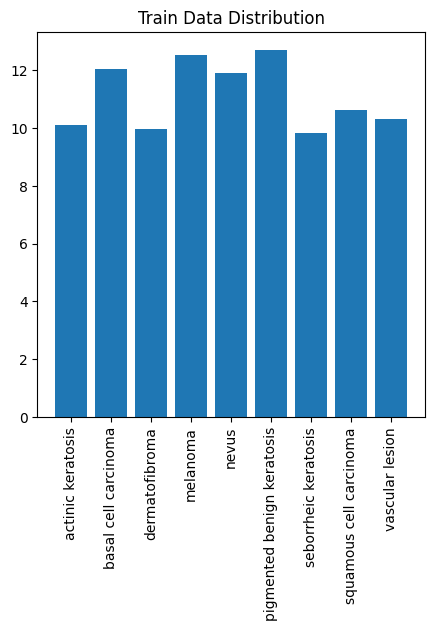

In [32]:
plt.figure(figsize=(5,5))
plt.bar(data_detail_pd.index,data_detail_pd['Total Percentage(Train)'])
plt.xticks(rotation=90)
plt.title("Train Data Distribution")
plt.show()

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Training model

In [33]:
# ------------------------------------------------------------------------
# Load the Train with Augmentation and Validation dataset
# ------------------------------------------------------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train_aug,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    # validation_split=0,
    # subset="training",
    interpolation='bicubic',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_val_aug,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    # validation_split=1.0,
    # subset="validation",
    interpolation='bicubic',
)

Found 10787 files belonging to 9 classes.
Found 452 files belonging to 9 classes.


In [34]:
# ------------------------------------------------------------------------
# Create model
# ------------------------------------------------------------------------
model5 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    #layers.Dropout(0.25),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    #layers.MaxPooling2D(),
    #layers.BatchNormalization(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    #layers.BatchNormalization(),
    #layers.Dropout(0.2),

    layers.Flatten(),

    layers.Dropout(0.2),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(num_classes)
    ],
    name="Model_05")

# ------------------------------------------------------------------------
# Compile model
# ------------------------------------------------------------------------
model5.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ------------------------------------------------------------------------
# View model
# ------------------------------------------------------------------------
model5.summary()

Model: "Model_05"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_4 (Bat  (None, 90, 90, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)        184

In [35]:
epochs = 70
history = model5.fit(train_ds, validation_data=val_ds, epochs=epochs)
model5.save('model5.h5')

Epoch 1/70
338/338 [==============================] - 32s 77ms/step - loss: 1.5818 - accuracy: 0.4130 - val_loss: 2.9743 - val_accuracy: 0.1040
Epoch 2/70
338/338 [==============================] - 26s 75ms/step - loss: 1.2665 - accuracy: 0.5268 - val_loss: 2.8691 - val_accuracy: 0.1615
Epoch 3/70
338/338 [==============================] - 25s 74ms/step - loss: 1.0078 - accuracy: 0.6314 - val_loss: 13.1667 - val_accuracy: 0.1195
Epoch 4/70
338/338 [==============================] - 25s 73ms/step - loss: 0.9975 - accuracy: 0.6386 - val_loss: 5.2619 - val_accuracy: 0.0708
Epoch 5/70
338/338 [==============================] - 26s 74ms/step - loss: 1.0704 - accuracy: 0.6203 - val_loss: 2.8976 - val_accuracy: 0.3186
Epoch 6/70
338/338 [==============================] - 25s 72ms/step - loss: 0.6777 - accuracy: 0.7635 - val_loss: 2.9459 - val_accuracy: 0.3274
Epoch 7/70
338/338 [==============================] - 25s 72ms/step - loss: 0.5705 - accuracy: 0.8022 - val_loss: 3.2125 - val_accuracy

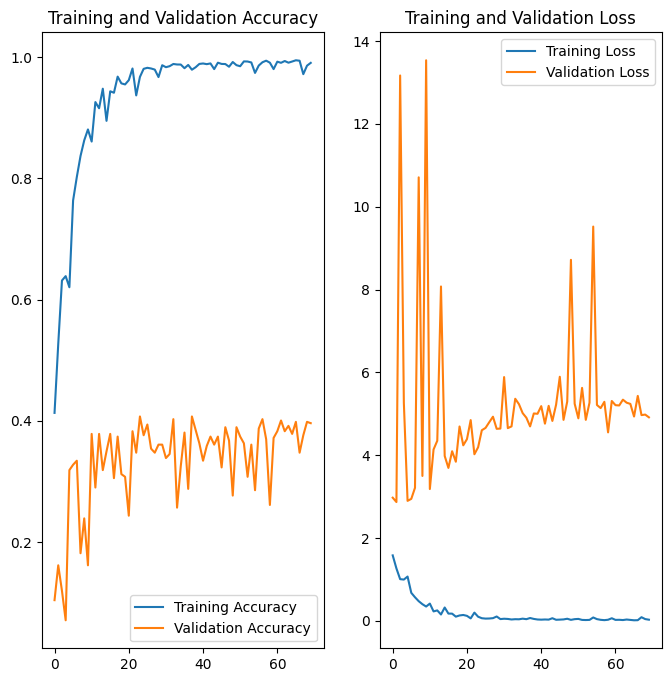

In [36]:
# ------------------------------------------------------------------------
# Visualize model
# ------------------------------------------------------------------------
visualize_history(history, epochs)

<strong>Findings</strong>
<ul>
    <li> Model overfit
    <li> Loss of validation increase from epoch 20, when model start overfit
<ul>

## Model 6: Better Model - Based on EfficientNetv2

In [37]:
def create_model6(input_shape, num_classes):
    model = Sequential()

    # Entry Flow
    model.add(Rescaling(scale=1./255.0, input_shape=input_shape))
    model.add(Conv2D(32, 3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('swish'))

    # Add more Conv2D, BatchNormalization, Activation layers as needed for the Entry Flow

    # Middle Flow (Repeat this block multiple times)
    for _ in range(3):  # You can adjust the number of repetitions
        model.add(Conv2D(64, 3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('swish'))
    
    # Add more Middle Flow blocks as needed

    # Exit Flow
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [38]:
# ------------------------------------------------------------------------
# Create model
# ------------------------------------------------------------------------
model6 = create_model6(input_shape=(img_height, img_width, 3), num_classes=9)

# ------------------------------------------------------------------------
# Compile model
# ------------------------------------------------------------------------
model6.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ------------------------------------------------------------------------
# View model
# ------------------------------------------------------------------------
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 90, 90, 32)        128       
 tchNormalization)                                               
                                                                 
 activation (Activation)     (None, 90, 90, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization_11 (Ba  (None, 90, 90, 64)        256       
 tchNormalization)                                    

In [39]:
epochs = 70
history = model6.fit(train_ds, validation_data=val_ds, epochs=epochs)
model6.save('model6.h5')

Epoch 1/70
338/338 [==============================] - 24s 62ms/step - loss: 1.5764 - accuracy: 0.3978 - val_loss: 2.4214 - val_accuracy: 0.2102
Epoch 2/70
338/338 [==============================] - 20s 59ms/step - loss: 1.4479 - accuracy: 0.4446 - val_loss: 1.9055 - val_accuracy: 0.3584
Epoch 3/70
338/338 [==============================] - 21s 61ms/step - loss: 1.3688 - accuracy: 0.4742 - val_loss: 4.4112 - val_accuracy: 0.1637
Epoch 4/70
338/338 [==============================] - 20s 59ms/step - loss: 1.3231 - accuracy: 0.4945 - val_loss: 2.5589 - val_accuracy: 0.3031
Epoch 5/70
338/338 [==============================] - 20s 59ms/step - loss: 1.2750 - accuracy: 0.5168 - val_loss: 3.6557 - val_accuracy: 0.1792
Epoch 6/70
338/338 [==============================] - 20s 59ms/step - loss: 1.2492 - accuracy: 0.5236 - val_loss: 2.7717 - val_accuracy: 0.2788
Epoch 7/70
338/338 [==============================] - 20s 59ms/step - loss: 1.2146 - accuracy: 0.5347 - val_loss: 3.9013 - val_accuracy:

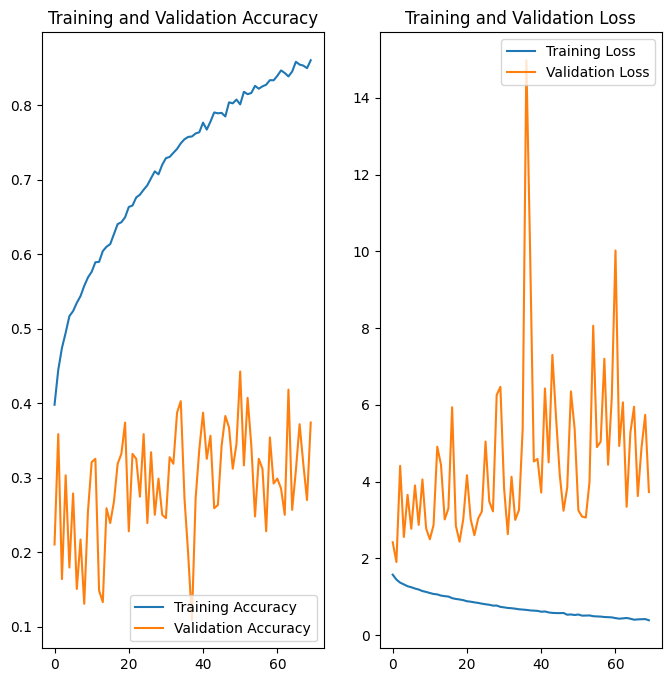

In [40]:
# ------------------------------------------------------------------------
# Visualize model
# ------------------------------------------------------------------------
visualize_history(history, epochs)

<strong>Findings</strong>
<ul>
    <li> Model still overfit
</ul>

## Model 7: Model 6 without data balancing

In [41]:
# ------------------------------------------------------------------------
# Reload the data
# ------------------------------------------------------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
    interpolation='bicubic',
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bicubic',
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [42]:
def create_model7(input_shape, num_classes):
    model = Sequential()

    # Entry Flow
    model.add(data_augument)
    model.add(Rescaling(scale=1./255.0, input_shape=input_shape))
    model.add(Conv2D(32, 3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('swish'))

    # Add more Conv2D, BatchNormalization, Activation layers as needed for the Entry Flow

    # Middle Flow (Repeat this block multiple times)
    for _ in range(3):  # You can adjust the number of repetitions
        model.add(Conv2D(64, 3, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('swish'))
    
    # Add more Middle Flow blocks as needed

    # Exit Flow
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [43]:
# ------------------------------------------------------------------------
# Create model
# ------------------------------------------------------------------------
model7 = create_model7(input_shape=(img_height, img_width, 3), num_classes=9)

# ------------------------------------------------------------------------
# Compile model
# ------------------------------------------------------------------------
model7.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ------------------------------------------------------------------------
# View model
# ------------------------------------------------------------------------
model7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 90, 90, 32)        896       
                                                                 
 batch_normalization_14 (Ba  (None, 90, 90, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_4 (Activation)   (None, 90, 90, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 90, 90, 64)        18496     
                                                      

In [44]:
# ------------------------------------------------------------------------
# Train model
# ------------------------------------------------------------------------
epochs = 70
history = model7.fit(train_ds, validation_data=val_ds, epochs=epochs)
model7.save('model7.h5')

Epoch 1/70
56/56 [==============================] - 10s 119ms/step - loss: 1.7159 - accuracy: 0.3834 - val_loss: 2.2116 - val_accuracy: 0.1499
Epoch 2/70
56/56 [==============================] - 8s 124ms/step - loss: 1.5577 - accuracy: 0.4431 - val_loss: 2.2741 - val_accuracy: 0.1499
Epoch 3/70
56/56 [==============================] - 8s 125ms/step - loss: 1.5340 - accuracy: 0.4542 - val_loss: 2.3316 - val_accuracy: 0.1499
Epoch 4/70
56/56 [==============================] - 8s 124ms/step - loss: 1.5145 - accuracy: 0.4442 - val_loss: 2.3494 - val_accuracy: 0.2416
Epoch 5/70
56/56 [==============================] - 7s 116ms/step - loss: 1.4930 - accuracy: 0.4609 - val_loss: 2.1062 - val_accuracy: 0.2125
Epoch 6/70
56/56 [==============================] - 7s 113ms/step - loss: 1.5030 - accuracy: 0.4537 - val_loss: 1.8123 - val_accuracy: 0.3110
Epoch 7/70
56/56 [==============================] - 7s 114ms/step - loss: 1.4615 - accuracy: 0.4632 - val_loss: 2.0100 - val_accuracy: 0.2685
Epoch

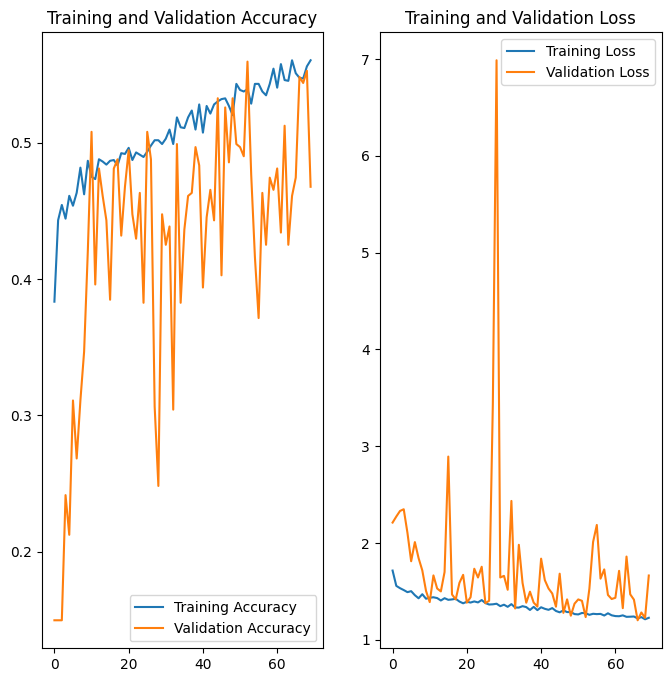

In [45]:
# ------------------------------------------------------------------------
# Visualize model
# ------------------------------------------------------------------------
visualize_history(history, epochs)

<strong>Findings</strong>
<ul>
    <li> Model still overfit but a little bit better than model 6
</ul>

# Testing and Conclusion

## Test data with all models

In [47]:
# ------------------------------------------------------------------------
# Load test data
# ------------------------------------------------------------------------
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation='bicubic',
)

# ------------------------------------------------------------------------
# Check the accuracy of each model on test data
# ------------------------------------------------------------------------
# List of model files
model_files = ["model1.h5", "model2.h5", "model3.h5", "model4.h5", "model5.h5", "model6.h5", "model7.h5"]

# Evaluate each model on the test dataset
best_model = None
best_accuracy = 0.0

for model_file in model_files:
    model = load_model(model_file)
    model_accuracy = model.evaluate(test_ds)[1]  # Get validation accuracy

    print(f"Model {model_file}: Accuracy = {model_accuracy:.2f}")
    
    if model_accuracy > best_accuracy:
        best_model = model
        best_accuracy = model_accuracy

print(f"The best model is {best_model} with accuracy {best_accuracy:.2f}")

Found 118 files belonging to 9 classes.
4/4 [==============================] - 6s 42ms/step - loss: 5.8890 - accuracy: 0.3390
Model model1.h5: Accuracy = 0.34
4/4 [==============================] - 2s 8ms/step - loss: 2.4092 - accuracy: 0.3814
Model model2.h5: Accuracy = 0.38
4/4 [==============================] - 2s 16ms/step - loss: 2.4329 - accuracy: 0.3644
Model model3.h5: Accuracy = 0.36
4/4 [==============================] - 2s 9ms/step - loss: 4.3552 - accuracy: 0.3390
Model model4.h5: Accuracy = 0.34
4/4 [==============================] - 2s 50ms/step - loss: 4.4085 - accuracy: 0.4068
Model model5.h5: Accuracy = 0.41
4/4 [==============================] - 3s 116ms/step - loss: 4.8507 - accuracy: 0.3475
Model model6.h5: Accuracy = 0.35
4/4 [==============================] - 2s 19ms/step - loss: 3.3952 - accuracy: 0.3136
Model model7.h5: Accuracy = 0.31
The best model is <keras.src.engine.sequential.Sequential object at 0x7f350c161600> with accuracy 0.41


## Conclusion based on best model accuracy and its confusion matrix

1/1 [==============================] - 0s 159ms/step


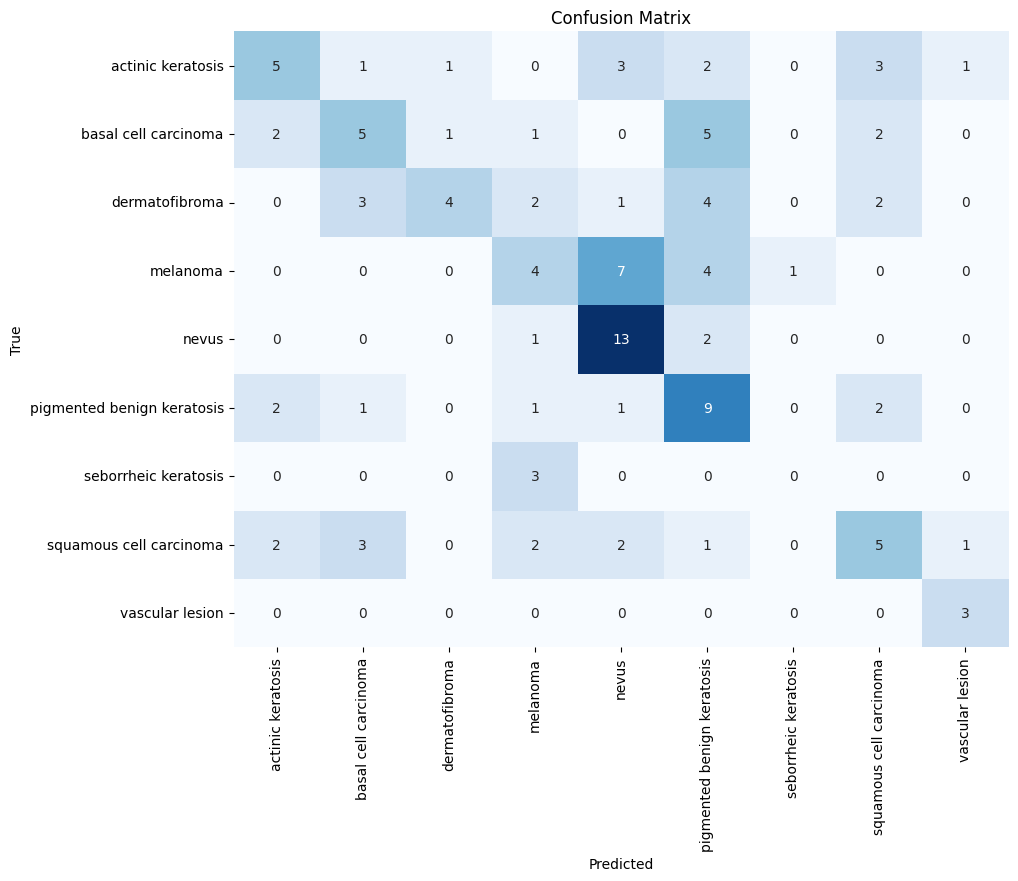

In [55]:
# ------------------------------------------------------------------------
# Confusion matrix of best model
# ------------------------------------------------------------------------
# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset to collect true labels and predicted labels
for batch in test_ds:
    images, labels = batch
    true_labels.extend(labels.numpy())  # Extract true labels
    predictions = best_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

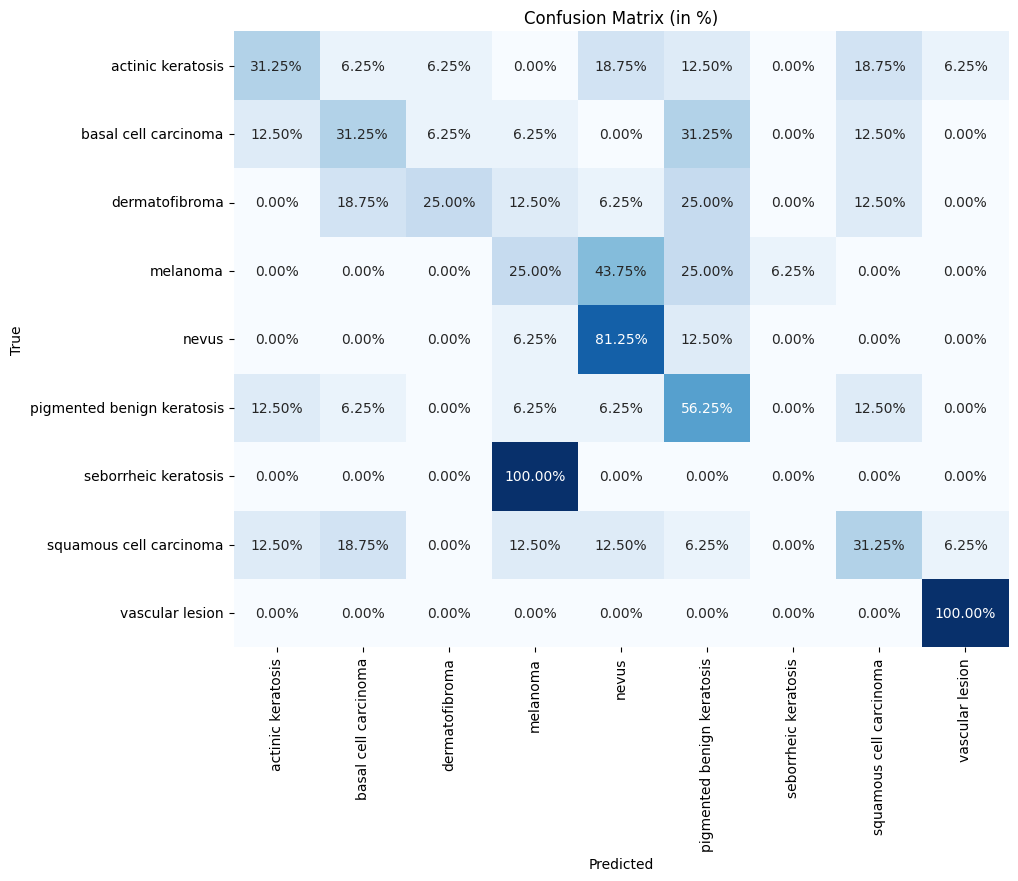

In [56]:
# Normalize the confusion matrix to get percentages
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix in percentage format
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (in %)')
plt.show()

<strong>Conclusion</strong>
<ul>
    <li> Augmentation help improve result a little bit
    <li> Due to very few sample, model is very easy to overfit when increasing model architect
    <li> The original sample is not general enough, train/test on a very different image -> not good. Based on my research, the Melanoma dataset full contains 33126 training sample, which will help to eleminate overfit problem
    <li> Data balancing duplicates the number of samples. However, as the above result, not help much due to very liitle type of image, and duplicate too much make model overfit
    <li> Too improve model, I suggest to use the original dataset, over 35K samples in total. Some DS experimenced accuracy over 90% with ResNet on their works
</ul>